In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from training import train_single_model

# from bokeh.plotting import figure, output_notebook, show
# output_notebook()
from IPython.display import IFrame

YEAR = 8766 # One year is 8766 hours
MONTH = 730.5 # One month is 730.5 hours
DATETIME_FMT = "%Y-%m-%d %H:%M"

if False:
  # https://github.com/jegesm/Presentation-tricks/blob/master/Jupyter/Change-the-outlook.md
  from IPython.core.display import display, HTML
  display(HTML("<style>.container { width:100% !important; }</style>"))
  display(HTML("<style>.slides {bottom: 0px !important; overflow-y: auto !important;}</style>"))
  # Hide scrollbar 
  # display(HTML("<style>.slides {\
  #     ::-webkit-scrollbar {\
  #         width: 0px;\
  #         background: transparent;\
  #     }\
  # }</style>"))
  #display(HTML("<script>Reveal.configure({ touch: false });</script>"))

In [2]:
import pandas as pd

# The table contains first flowering dates of 329 taxa over 33 years
# numbers are the day of year
df = pd.read_csv('./data/V_KEZD_Excel_SORTED_cut.csv', skiprows=1)
df.head(5)

,E.sz.,1968,1969,1970,1971,1972,1973,1974,1975,1976,...,1996,1997,1998,1999,2000,MEAN,STD,1st yr.,Last yr.,Nr.of yrs
0,3,46,61.0,66.0,39.0,41.0,31.0,25.0,5.0,37.0,...,63.0,37.0,20.0,57.0,39.0,36.303030,15.899473,NaN,NaN,33.0
1,3,46,62.0,68.0,42.0,46.0,39.0,37.0,19.0,51.0,...,59.0,37.0,17.0,57.0,32.0,37.727273,16.273892,NaN,NaN,33.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,37.0,...,60.0,30.0,22.0,57.0,37.0,41.913043,14.999758,NaN,NaN,22.5
3,3,49,68.0,72.0,44.0,48.0,42.0,37.0,17.0,57.0,...,66.0,37.0,20.0,57.0,40.0,42.424242,17.968977,NaN,NaN,33.0
4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,...,75.0,47.0,46.0,58.0,45.0,46.458333,13.356584,NaN,NaN,23.5


In [3]:
"""
Helper functions for date & time handling
"""
from datetime import datetime
from datetime import timezone

def datetimeToHour(dt):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_dt = datetime.strptime(dt, DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    return int((ts_dt-ts_null)//3600-692496)
datetimeToHour = np.vectorize(datetimeToHour)

def hourToTimestamp(h):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_date = int(ts_null) + 692496*3600 + 3600*h
    return ts_date
hourToTimestamp = np.vectorize(hourToTimestamp)

def hourToUTC(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts)
hourToUTC = np.vectorize(hourToUTC)

def hourToUTCFormatted(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts).strftime(DATETIME_FMT)
hourToUTCFormatted = np.vectorize(hourToUTCFormatted)

def getYearBeforeDateTime(dt):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-YEAR
    if hr_start < 0:
       raise ValueError("hr_start < 0")
    return hr_start, hr_end

def getMonthsBeforeDateTime(dt, nmonths):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-int(nmonths*MONTH)
    if hr_start < 0:
       raise ValueError("hr_start < 0")
    return hr_start, hr_end
  
def getYearBeforeTimestamp(ts):
    pass
  
import ephem     # provides scientific-grade astronomical computations
"""
IMPORTANT:
PyEphem dates are encoded as the “Dublin Julian Day”, which is the number of
days (including any fraction) that have passed since the last day of 1899, at noon. 
"""
def getsoltime(dt, long):
    gamma = 2. * np.pi / 365. * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24)
    eqtime = 229.18 * (0.000075 + 0.001868 * np.cos(gamma) - 0.032077 * np.sin(gamma) \
             - 0.014615 * np.cos(2 * gamma) - 0.040849 * np.sin(2 * gamma))
    decl = 0.006918 - 0.399912 * np.cos(gamma) + 0.070257 * np.sin(gamma) \
           - 0.006758 * np.cos(2 * gamma) + 0.000907 * np.sin(2 * gamma) \
           - 0.002697 * np.cos(3 * gamma) + 0.00148 * np.sin(3 * gamma)
    time_offset = eqtime + 4 * long
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst)
    return solar_time
  
def getsunrise_sunset(date, lat=47.5, lon=19.0):
    iss = ephem.Observer()
    iss.date = date
    iss.lat = str(lat)                     # IMPORTANT TO CONVERT INTO STRING!!!
    iss.lon = str(lon)
    iss.elevation = 130                   # elevation of Albertfalva (in units of m)
    sun = ephem.Sun()
    r1 = iss.next_rising(sun)
    s1 = iss.next_setting(sun)
    return r1,s1

def tm(hour):
    # Calculate time at dawn for a given hour
    date = ephem.Date(str(hourToUTCFormatted(hour)))
    rs1, st1 = getsunrise_sunset(date)
    formatted = datetime.strftime(rs1.datetime(), DATETIME_FMT)
    return datetimeToHour(formatted)
tm = np.vectorize(tm)

"""
Some more helper funcs to get the data based on the csv file
"""
def utcFromYearAndDay(yr, day):
    if type(yr) == int:
        yr = str(yr)
    hours = datetimeToHour(
      datetime.strftime(datetime.strptime(yr, "%Y"),
                       DATETIME_FMT)
    )
    hours = hours + day*24
    return hourToUTCFormatted(hours)

def tempDataForYearAndDay(yr, day, nmonths, transformTime=False):
    """
     Return t, and T for nmonths backward from a given date
    """
    hrs, hre = getMonthsBeforeDateTime(utcFromYearAndDay(yr, day), nmonths=18)
    slc = slice(hrs, int(hre), 1)
    ts = hours[slc]
    Ts = temps[slc]
    if transformTime == True:
        ts = ts-np.max(ts)
    return ts, Ts

In [4]:
ds = Dataset("./data/ERA5-hourly-merged.nc")
stl2 = np.array(ds.variables['stl2'])
long = np.array(ds.variables['longitude'])
lat = np.array(ds.variables['latitude'])
print("lat = {} long = {}".format(lat[0], long[0]))

# the relevant data is stl2[0][0]
temps = np.array([x[0][0] for x in stl2]).astype(float)
hours = np.array(ds.variables['time']) 

lat = 47.5 long = 19.0


In [5]:
# Select data
rowindex = 0

# Hack
flowering_dates = list(
    zip(
      list(df.iterrows())[rowindex][1].keys(),
      list(df.iterrows())[rowindex][1].values
    )
)

# Filter out columns with years
flowering_dates = [fd for fd in flowering_dates if fd[0].isdigit()]
print(flowering_dates)

[('1968', '46'), ('1969', 61.0), ('1970', 66.0), ('1971', 39.0), ('1972', 41.0), ('1973', 31.0), ('1974', 25.0), ('1975', 5.0), ('1976', 37.0), ('1977', 30.0), ('1978', 32.0), ('1979', 35.0), ('1980', 46.0), ('1981', 32.0), ('1982', 51.0), ('1983', 19.0), ('1984', 35.0), ('1985', 64.0), ('1986', 65.0), ('1987', 48.0), ('1988', 21.0), ('1989', 21.0), ('1990', 24.0), ('1991', 12.0), ('1992', 31.0), ('1993', 23.0), ('1994', 13.0), ('1995', 29.0), ('1996', 63.0), ('1997', 37.0), ('1998', 20.0), ('1999', 57.0), ('2000', 39.0)]


In [6]:
days_before_flowering_max = 90

In [7]:
data = []
for fd in flowering_dates:
    for k in range(days_before_flowering_max):
        yr = int(fd[0])
        day = int(fd[1]) - k
        try:
            ts, Ts = tempDataForYearAndDay(yr, day, nmonths=12)
            data.append((Ts, k))
        except:
            pass
            #print("Creating data for year {} day {} failed.".format(int(fd[0]), int(fd[1])-k))
            
"""
   Tensorize data
"""
data = list(map(lambda x: (torch.tensor(x[0]), x[1]), data))

X = list(map(lambda x: x[0].unsqueeze(-1).to(torch.float32), data))
y = list(map(lambda x: torch.tensor([x[1]]).to(torch.float32), data))

"""
    Train-test split 
"""
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

"""
    Create batches
"""
BS = 8 # batch size
def chunks(a, n):
    for i in range(0, len(a), n):
        yield a[i:i + n]
        
X_train_batches = list(chunks(X_train, BS))
y_train_batches = list(chunks(y_train, BS))

X_test_batches = list(chunks(X_test, BS))
y_test_batches = list(chunks(y_test, BS))

In [8]:
class LSTM_Baseline(nn.Module):
    def __init__(self, hidden_size=16):
        super(LSTM_Baseline, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTM(1, self.hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size,1)
    def forward(self, x):
        x, (hn, cn) = self.LSTM(x)
        hn = hn.squeeze(0)
        return F.relu(self.fc(hn))

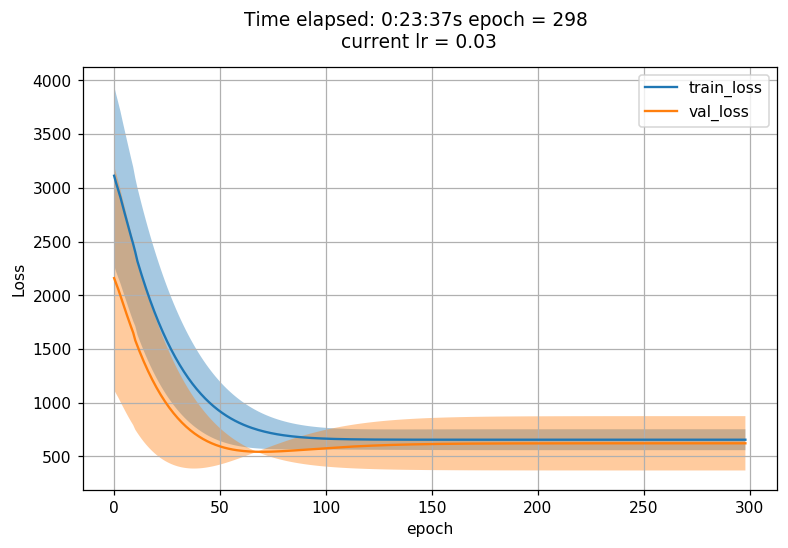

In [10]:
"""
    Start training
"""
model = LSTM_Baseline()

def crit(opt, y):
    return F.mse_loss(y, opt)

h, m = train_single_model(
    model, 
    300, 
    [(torch.stack(batch),) for batch in X_train_batches[:4]],
    [torch.stack(batch) for batch in y_train_batches[:4]],
    X_val_batches=[(torch.stack(batch),) for batch in X_test_batches[:2]],
    y_val_batches=[torch.stack(batch) for batch in y_test_batches[:2]],
    criterion=crit,
    optimizer=torch.optim.Adam, # optimizer=torch.optim.Adam,
    optimizer_args=dict(lr=3e-2, amsgrad=True),
    device='cuda:2',
    #train_metrics_cb=crit,
    #val_metrics_cb=crit,
    plot_losses=True,
    plot_metrics=True,
)